In [ ]:
from google.colab import drive
import os
# Set TensorFlow to be deterministic
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import cv2
from PIL import Image
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import apply_affine_transform
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plt
import matplotlib.image as im
from tqdm import tqdm
import seaborn as sns
from imblearn.combine import SMOTETomek

In [ ]:
# Set the random seed for reproducibility

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

kernel_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed)

In [ ]:
# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    labels = []
    input_shape = (240, 240, 3)  # Define the shape to resize the images

    # Iterate through each subfolder in the main folder
    for class_folder in tqdm(os.listdir(folder_path)):
        class_folder_path = os.path.join(folder_path, class_folder)

        # Check if the path is a directory (to avoid hidden files)
        if os.path.isdir(class_folder_path):
            # Iterate through each image in the subfolder
            for filename in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path, filename)

                # Read the image using OpenCV
                img = cv2.imread(img_path)

                # Check if the image is successfully loaded
                if img is not None:
                    # Resize the image
                    img = cv2.resize(img, (input_shape[1], input_shape[0]))

                    # Append the image and its class label to the lists
                    images.append(img)
                    labels.append(class_folder)
                else:
                    print(f"Failed to load image: {img_path}")

    return images, labels

# Mount Google Drive
drive.mount('/content/drive')

# Path to the main folder containing class folders in Google Drive
main_folder_path = "/content/drive/My Drive/Datasets/harvard_dataverse_v1"

# Load images and labels
images, labels = load_images_from_folder(main_folder_path)

# Display the number of images and labels loaded
print(f"Loaded {len(images)} images with {len(set(labels))} unique labels.")

Mounted at /content/drive


100%|██████████| 3/3 [00:59<00:00, 19.95s/it]

Loaded 1544 images with 3 unique labels.


['0' '1' '2']


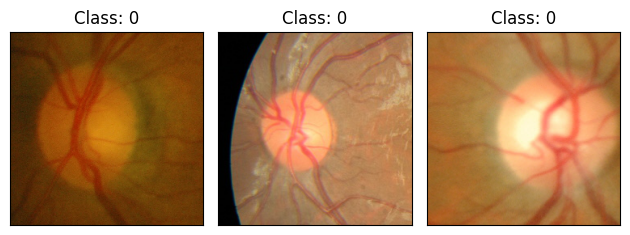

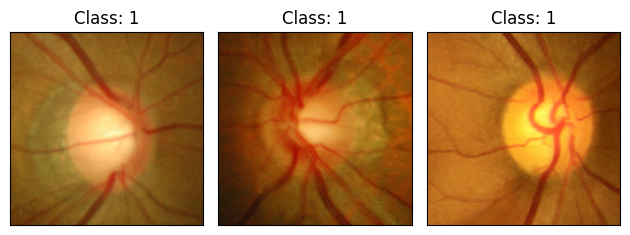

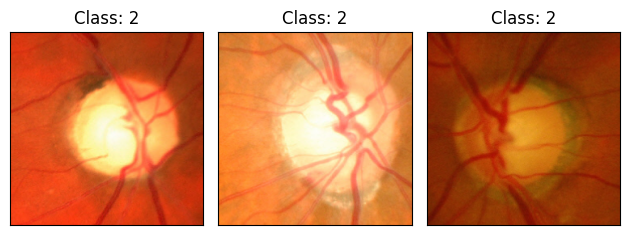

In [ ]:
#View the first 3 images for each classes
# 0 - Normal
# 1 - Early
# 2 - Advanced

# Assuming classes is a list of unique class labels
classes = np.unique(labels)
print(classes)

for class_label in classes:
    # Select indices corresponding to the current class
    class_indices = [i for i, label in enumerate(labels) if label == class_label]

    # Display the first three images from the current class
    for i in range(min(3, len(class_indices))):
        plt.subplot(1, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(cv2.cvtColor(images[class_indices[i]], cv2.COLOR_BGR2RGB))
        plt.title(f"Class: {class_label}")
    plt.tight_layout()
    plt.show()

In [ ]:
# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [ ]:
#Check for shape of the dataset

images.shape

(1544, 240, 240, 3)

array([[[ 10,  37,  64],
        [  7,  33,  63],
        [ 10,  38,  68],
        ...,
        [ 14,  61, 122],
        [ 10,  60, 118],
        [  5,  59, 114]],

       [[  7,  34,  61],
        [  0,  25,  55],
        [  8,  34,  64],
        ...,
        [  8,  57, 119],
        [  8,  59, 121],
        [  3,  57, 117]],

       [[  6,  33,  59],
        [  8,  35,  61],
        [  8,  35,  62],
        ...,
        [  9,  57, 123],
        [  6,  56, 122],
        [  3,  57, 122]],

       ...,

       [[  5,  36,  59],
        [  8,  39,  62],
        [ 12,  43,  66],
        ...,
        [ 11,  62, 105],
        [  3,  52, 100],
        [  7,  54, 105]],

       [[ 11,  42,  65],
        [ 10,  41,  62],
        [ 10,  42,  61],
        ...,
        [  7,  56, 104],
        [  8,  57, 107],
        [ 11,  58, 109]],

       [[  9,  39,  66],
        [  8,  39,  64],
        [ 14,  45,  68],
        ...,
        [ 10,  58, 110],
        [  4,  53, 103],
        [  2,  51,  99]]], dtype=uint8)
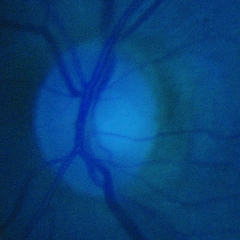

In [ ]:
images[0]

In [ ]:
# Save processes images and labels on computer

file_path = 'images.npy'
np.save(file_path, images)

file_path = 'labels.npy'
np.save(file_path, labels)

In [ ]:
# Confirm how many values are in each class

unique_values, counts = np.unique(labels, return_counts=True)
print(f"{unique_values}, \n{counts}")

['0' '1' '2'], 
[788 289 467]


In [ ]:
images.shape

(1544, 240, 240, 3)

In [ ]:
# Reshape the images array to have 4 dimensions if necessary
if len(images.shape) == 4:
    images = images.reshape(images.shape[0], -1)

# Handle imblance dataset with SMOTE + Tomek
smtom = SMOTETomek(random_state=random_seed)
images_smtom, labels_smtom = smtom.fit_resample(images, labels)

# Handle imbalance dataset with SMOTE + ENN

In [ ]:
unique_values, counts = np.unique(labels_smtom, return_counts=True)
print(f"{unique_values}, \n{counts}")

['0' '1' '2'], 
[755 755 756]


In [ ]:
print(len(images_smtom))
print(len(labels_smtom))

2266
2266


In [ ]:
# Split the dataset into train, validation and test sets in 80%, 10%, 10%

x_train, x_split, y_train, y_split = train_test_split(images_smtom, labels_smtom, test_size=0.2, random_state=random_seed, stratify=labels_smtom)
x_val, x_test, y_val, y_test = train_test_split(x_split, y_split, test_size=0.5, random_state=random_seed, stratify=y_split)

In [ ]:
unique_values, counts = np.unique(y_train, return_counts=True)
print(f"{unique_values}, \n{counts}")

unique_values, counts = np.unique(y_val, return_counts=True)
print(f"{unique_values}, \n{counts}")

unique_values, counts = np.unique(y_test, return_counts=True)
print(f"{unique_values}, \n{counts}")

['0' '1' '2'], 
[604 604 604]
['0' '1' '2'], 
[75 76 76]
['0' '1' '2'], 
[76 75 76]


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
# Reshape input data to the expected shape
x_train = x_train.reshape(-1, 240, 240, 3)
x_val = x_val.reshape(-1, 240, 240, 3)
x_test = x_test.reshape(-1, 240, 240, 3)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1812, 240, 240, 3)
(227, 240, 240, 3)
(227, 240, 240, 3)
(1812, 3)
(227, 3)
(227, 3)


In [ ]:
### The Model - Resnet50

In [ ]:
#Import ResNet 50

input_shape = (240, 240, 3)
#input_shape = (224, 224, 3)

resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=input_shape,
    pooling='max'
)

#for layer in resnet50.layers:
#   layer.trainable=False

94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
# Create the model architecture

# Create a new sequential model
model = models.Sequential()

# Add the ResNet50 base model
model.add(resnet50)

# Flatten the output of the ResNet50 model
model.add(layers.Flatten())

# Add additional dense layers
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(128, activation='relu'))
#model.add(layers.BatchNormalization())


# Add the output layer with softmax activation for multiclass classification
model.add(layers.Dense(3, activation='softmax'))

# Set initial layer training behavior
resnet50.trainable = False

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

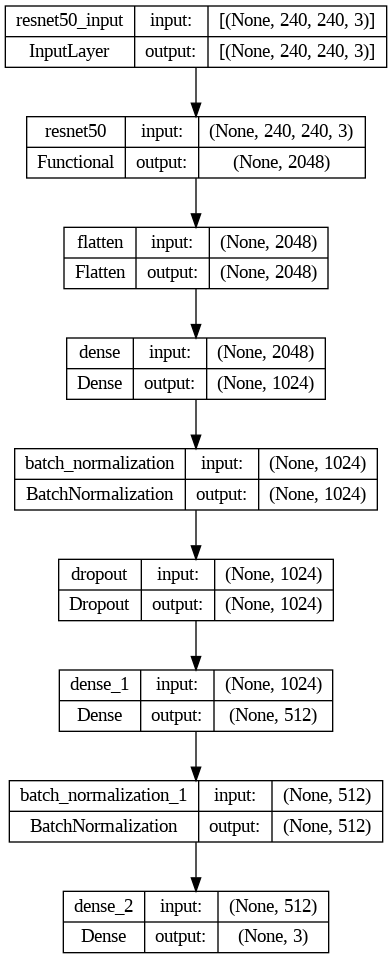

In [ ]:
plot_model(model, to_file="/content/finalmodel_plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
# Define the learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your training setup
    decay_rate=0.9,   # Adjust this value based on your preference
    staircase=True)

In [ ]:
# Define the optimizer with the learning rate schedule

optimizer = optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
#Define earlystopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
# Data augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        shear_range=0.2,
        zca_whitening=False,
        zoom_range=0.0,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True, # randomly flip images
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.1
)


datagen.fit(x_train, seed=random_seed)

In [ ]:
x_train.shape

(1812, 240, 240, 3)

In [ ]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32, seed=random_seed),
                    validation_data=(x_val, y_val),
                    epochs=60,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/60
57/57 [==============================] - 45s 635ms/step - loss: 2.2817 - accuracy: 0.6242 - val_loss: 2.2787 - val_accuracy: 0.6520
Epoch 2/60
57/57 [==============================] - 35s 607ms/step - loss: 2.0626 - accuracy: 0.6843 - val_loss: 2.1700 - val_accuracy: 0.6476
Epoch 3/60
57/57 [==============================] - 37s 643ms/step - loss: 1.9600 - accuracy: 0.7318 - val_loss: 2.0887 - val_accuracy: 0.6784
Epoch 4/60
57/57 [==============================] - 34s 603ms/step - loss: 1.9156 - accuracy: 0.7406 - val_loss: 1.8933 - val_accuracy: 0.7489
Epoch 5/60
57/57 [==============================] - 34s 597ms/step - loss: 1.8546 - accuracy: 0.7643 - val_loss: 1.9769 - val_accuracy: 0.7357
Epoch 6/60
57/57 [==============================] - 35s 620ms/step - loss: 1.8411 - accuracy: 0.7632 - val_loss: 1.9579 - val_accuracy: 0.7665
Epoch 7/60
57/57 [==============================] - 34s 589ms/step - loss: 1.8038 - accuracy: 0.7870 - val_loss: 1.8290 - val_accuracy: 0.7841

In [ ]:
#Evaluate the model

loss, accuracy = model.evaluate(x_test, y_test)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

8/8 [==============================] - 1s 89ms/step - loss: 1.5913 - accuracy: 0.7753
Test loss:  1.59132981300354
Accuracy:  0.7753304243087769


In [ ]:
# Fine-Tuning: Unlock specific layers of the base model
# In this example, we'll unlock the last 5 layers
fine_tune_at = -5  # unlock the last 5 layers
resnet50.trainable = True

# Set all layers before 'fine_tune_at' to not trainable
for layer in resnet50.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Re-compile the model after unlocking the layers
optimizer_fine_tune = optimizers.Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
model.compile(
    optimizer=optimizer_fine_tune,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Continue training with fine-tuning
history_fine_tuning = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=60,  # Fine-tune for more epochs
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/60
57/57 [==============================] - 42s 646ms/step - loss: 1.2519 - accuracy: 0.8653 - val_loss: 1.4541 - val_accuracy: 0.7533
Epoch 2/60
57/57 [==============================] - 35s 612ms/step - loss: 1.1491 - accuracy: 0.8681 - val_loss: 1.3317 - val_accuracy: 0.7974
Epoch 3/60
57/57 [==============================] - 33s 587ms/step - loss: 1.0833 - accuracy: 0.8631 - val_loss: 1.3587 - val_accuracy: 0.7753
Epoch 4/60
57/57 [==============================] - 35s 623ms/step - loss: 1.0027 - accuracy: 0.8874 - val_loss: 1.2623 - val_accuracy: 0.8106
Epoch 5/60
57/57 [==============================] - 34s 604ms/step - loss: 1.0155 - accuracy: 0.8709 - val_loss: 1.3083 - val_accuracy: 0.7445
Epoch 6/60
57/57 [==============================] - 36s 618ms/step - loss: 0.9731 - accuracy: 0.8775 - val_loss: 1.1892 - val_accuracy: 0.7665
Epoch 7/60
57/57 [==============================] - 34s 601ms/step - loss: 0.9699 - accuracy: 0.8709 - val_loss: 1.2614 - val_accuracy: 0.7797

In [ ]:
#Evaluate the model

loss, accuracy = model.evaluate(x_test, y_test)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

8/8 [==============================] - 1s 96ms/step - loss: 1.3522 - accuracy: 0.7665
Test loss:  1.3521920442581177
Accuracy:  0.7665198445320129


In [ ]:
# Fine-Tuning: Unlock specific layers of the base model
# In this example, we'll unlock the last 5 layers
fine_tune_at = -5  # unlock the last 5 layers
resnet50.trainable = True

# Set all layers before 'fine_tune_at' to not trainable
for layer in resnet50.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model after unlocking the layers
optimizer_fine_tune = optimizers.Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
model.compile(
    optimizer=optimizer_fine_tune,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_fine_tuning = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=60,  # Fine-tune for more epochs
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/60
57/57 [==============================] - 41s 622ms/step - loss: 0.7932 - accuracy: 0.9029 - val_loss: 2.1530 - val_accuracy: 0.5991
Epoch 2/60
57/57 [==============================] - 34s 605ms/step - loss: 0.7461 - accuracy: 0.9238 - val_loss: 1.1832 - val_accuracy: 0.7753
Epoch 3/60
57/57 [==============================] - 35s 622ms/step - loss: 0.7469 - accuracy: 0.9067 - val_loss: 1.0557 - val_accuracy: 0.7621
Epoch 4/60
57/57 [==============================] - 35s 616ms/step - loss: 0.7007 - accuracy: 0.9238 - val_loss: 1.1191 - val_accuracy: 0.7885
Epoch 5/60
57/57 [==============================] - 34s 599ms/step - loss: 0.7034 - accuracy: 0.9156 - val_loss: 1.3154 - val_accuracy: 0.8018
Epoch 6/60
57/57 [==============================] - 37s 643ms/step - loss: 0.6841 - accuracy: 0.9299 - val_loss: 1.0329 - val_accuracy: 0.8150
Epoch 7/60
57/57 [==============================] - 36s 637ms/step - loss: 0.6937 - accuracy: 0.9172 - val_loss: 1.0721 - val_accuracy: 0.7753

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

8/8 [==============================] - 1s 91ms/step - loss: 1.0351 - accuracy: 0.8194
Test loss:  1.0351085662841797
Accuracy:  0.8193832635879517


Text(0.5, 1.0, 'Categorical Accuracy')

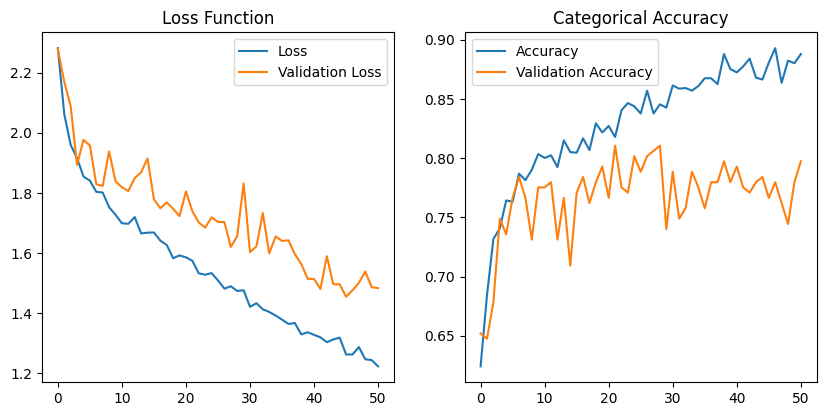

In [ ]:
#Plot Loss & Accuracy Loss for Train & Validation Dataset

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Function')


plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Categorical Accuracy')

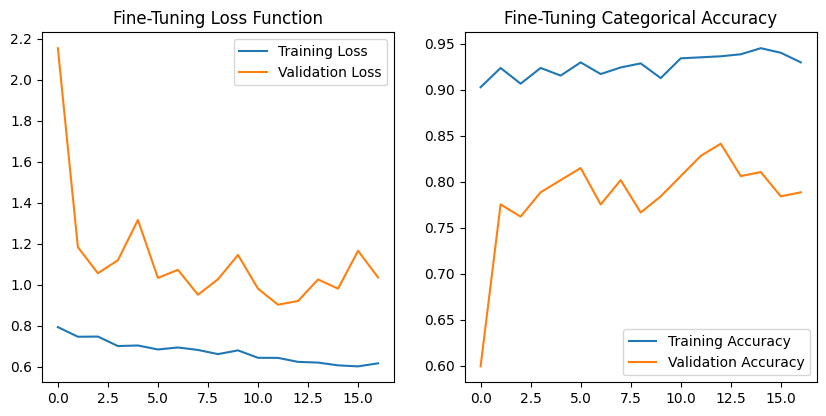

In [ ]:
# Plotting Loss and Accuracy for the fine-tuned model

plt.figure(figsize=(10, 10))  # Adjust the size as needed

# Plot loss for training and validation sets
plt.subplot(2, 2, 1)
plt.plot(history_fine_tuning.history['loss'], label='Training Loss')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Fine-Tuning Loss Function')

# Plot accuracy for training and validation sets
plt.subplot(2, 2, 2)
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Fine-Tuning Categorical Accuracy')

plt.show()  # Display the plot

In [ ]:
y_pred = model.predict(x_test)


8/8 [==============================] - 2s 108ms/step


In [ ]:
print(y_pred[0])
print(y_test[0])

[3.47532587e-05 1.40072545e-02 9.85957921e-01]
[0. 0. 1.]


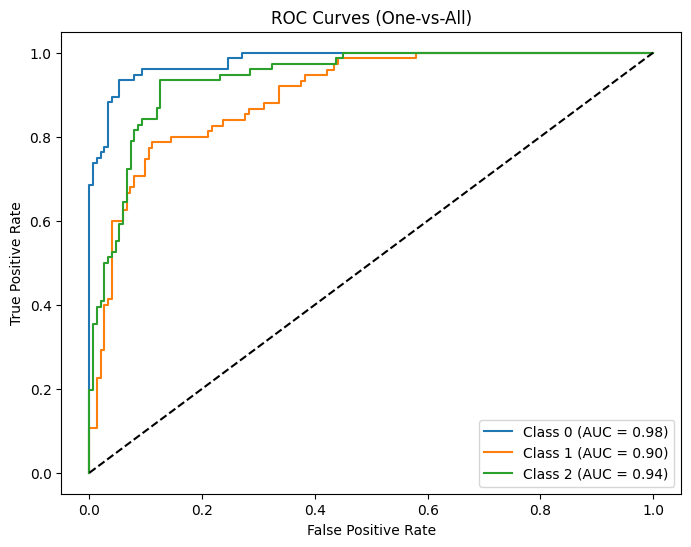

In [ ]:
# Calculate ROC-AUC for each class
n_classes = y_test.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])

# Plot ROC-AUC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-All)")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# To print weighted average AUC

n_classes = y_test.shape[1]

# Compute the class weights based on the number of samples in each class
class_counts = np.sum(y_test, axis=0)
total_samples = np.sum(class_counts)

class_weights = class_counts / total_samples  # Normalize to sum to 1

# Calculate weighted average ROC-AUC
weighted_roc_auc = 0
for i in range(n_classes):
    class_auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    weighted_roc_auc += class_weights[i] * class_auc

print(f"Weighted Average ROC-AUC: {weighted_roc_auc:.2f}")

Weighted Average ROC-AUC: 0.94


In [ ]:
Y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_test, axis=1)

print(Y_pred[0])
print(Y_test[0])

2
2


In [ ]:

model_performance = accuracy_score(Y_test, Y_pred)
model_performance

0.8193832599118943

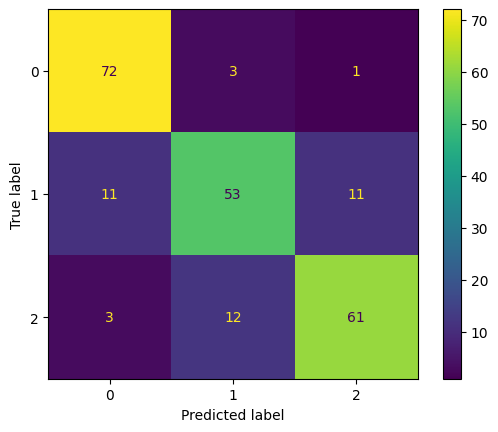

In [ ]:
# Get the true labels and predicted labels
# y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
# y_pred = np.argmax(model.predict(test_dataset_tuned), axis=1)


# Convert y_true to match the shape of y_pred
# y_true_argmax = np.argmax(y_true, axis=0)


# Calculate the confusion matrix
confusion_matrix = confusion_matrix(Y_test, Y_pred)
labels = ['0', '1', '2']
ConfusionMatrixDisplay(confusion_matrix, display_labels=labels).plot()

In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        76
           1       0.78      0.71      0.74        75
           2       0.84      0.80      0.82        76

    accuracy                           0.82       227
   macro avg       0.82      0.82      0.82       227
weighted avg       0.82      0.82      0.82       227



In [ ]:

model_name = "my_model_Final.h5"  # File name for saving the model

In [ ]:
model.save(model_name)  # Save the model in the Colab environment

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>